In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler

import folium as g
#플롯에서 한글이 깨지는 경우가 없도록 폰트 지정
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [2]:
scaler = MinMaxScaler()

df = pd.read_csv('회귀분석_Lasso기반 청년인프라지수.csv', encoding='cp949')

df = df.drop('Unnamed: 0',axis=1)
df.set_index('시군구', inplace=True)

#시군구 위경도 데이터 불러오기
df_loc = pd.read_csv('시군구_위경도.csv', encoding='cp949')
df_loc = df_loc.drop(['Unnamed: 4'], axis = 1) #비어있는 열 제거 

df_loc = df_loc.loc[0:74] #세종까지 행을 자름
df_loc = df_loc.set_index('name') # 인덱스를 시군구로 지정

#위경도를 붙어줌
df_loc_merge = df.join(df_loc, how='left')
df_loc_merge

,청년인구,병원,사회스포츠,대학교,초중고,공항,소방서,경찰서,소형상업시설(음식점_카페_학원_편의점),대형상업시설,숙박시설,기차역,행정기관,"법원, 교도소",문화시설_영화/공연/미술관박물관,버스터미널,청년인프라지수,id,lat,lon
시군구,,,,,,,,,,,,,,,,,,,,
서울_종로구,32943.0,496,28.0,3,60.0,0,1,23,5730,24,201,0,19.0,0.0,367.0,0.0,2.597156,11110.0,37.594920,126.977317
서울_중구,28277.0,572,16.0,2,48.0,0,1,17,5383,62,281,1,18.0,0.0,77.0,0.0,1.991037,11140.0,37.560143,126.995968
서울_용산구,52554.0,319,19.0,1,47.0,0,1,9,5056,23,104,9,18.0,1.0,48.0,0.0,6.336887,11170.0,37.531386,126.979908
서울_성동구,67271.0,457,21.0,2,69.0,0,1,10,4562,22,62,3,19.0,0.0,31.0,0.0,5.511858,11200.0,37.551030,127.041059
서울_광진구,91126.0,558,76.0,3,76.0,0,1,12,5609,26,66,0,17.0,0.0,25.0,1.0,6.133916,11215.0,37.546722,127.085746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
울산_남구,64670.0,618,24.0,1,106.0,0,1,6,7460,16,244,4,16.0,2.0,18.0,3.0,4.040873,31140.0,35.516052,129.328190
울산_동구,26280.0,174,18.0,1,60.0,0,1,5,3107,3,71,0,10.0,0.0,4.0,0.0,5.464600,31170.0,35.525580,129.426070
울산_북구,41455.0,172,30.0,0,94.0,1,1,5,3492,11,52,2,9.0,0.0,9.0,0.0,8.043699,31200.0,35.610062,129.379802


In [29]:
df_loc_merge = df_loc_merge.rename(columns={'소형상업시설(음식점_카페_학원_편의점)':'소형상업시설'})
df_loc_merge = df_loc_merge.rename(columns={'문화시설_영화/공연/미술관박물관':'문화시설'})

df_loc_merge.to_csv("이름 깔끔하게.csv", encoding="cp949")

In [3]:
def get_outlier(df, column, weight=1.5):
    # 이상치가 있는 index 반환
    
    # 1/4분위와 3/4분위 지점 지정
    quantile_25 = np.percentile(df[column].values, 25) #Q1
    quantile_75 = np.percentile(df[column].values, 75) #Q3
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR * weight
    
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
    
    # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고, index 반환
    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    
    return outlier_idx
#linear 데이터
outlier_linear_idx1 = get_outlier(df_loc_merge, '병원')
print("이상치 데이터 index1: ", outlier_linear_idx1)

outlier_linear_idx2 = get_outlier(df_loc_merge, '사회스포츠')
print("이상치 데이터 index2: ", outlier_linear_idx2)

outlier_linear_idx3 = get_outlier(df_loc_merge, '경찰서')
print("이상치 데이터 index3: ", outlier_linear_idx3)

outlier_linear_idx4 = get_outlier(df_loc_merge, '소형상업시설(음식점_카페_학원_편의점)')
print("이상치 데이터 index4: ", outlier_linear_idx4)

outlier_linear_idx5 = get_outlier(df_loc_merge, '대형상업시설')
print("이상치 데이터 index5: ", outlier_linear_idx5)

이상치 데이터 index1:  Index(['서울_서초구', '서울_강남구', '서울_송파구'], dtype='object', name='시군구')
이상치 데이터 index2:  Index(['서울_강남구'], dtype='object', name='시군구')
이상치 데이터 index3:  Index(['서울_종로구'], dtype='object', name='시군구')
이상치 데이터 index4:  Index(['서울_강남구'], dtype='object', name='시군구')
이상치 데이터 index5:  Index(['서울_중구'], dtype='object', name='시군구')


In [10]:
df_copy = df_loc_merge.copy()

df_copy.drop(outlier_linear_idx1, axis=0, inplace=True)
df_copy.drop(outlier_linear_idx3, axis=0, inplace=True)
df_copy.drop(outlier_linear_idx5, axis=0, inplace=True)

df_copy = df_copy.drop(['인천_옹진군']) # 인프라지수가 -18인 특이값 제거
df_copy

,청년인구,병원,사회스포츠,대학교,초중고,공항,소방서,경찰서,소형상업시설(음식점_카페_학원_편의점),대형상업시설,숙박시설,기차역,행정기관,"법원, 교도소",문화시설_영화/공연/미술관박물관,버스터미널,청년인프라지수,id,lat,lon
시군구,,,,,,,,,,,,,,,,,,,,
서울_용산구,52554.0,319,19.0,1,47.0,0,1,9,5056,23,104,9,18.0,1.0,48.0,0.0,6.336887,11170.0,37.531386,126.979908
서울_성동구,67271.0,457,21.0,2,69.0,0,1,10,4562,22,62,3,19.0,0.0,31.0,0.0,5.511858,11200.0,37.551030,127.041059
서울_광진구,91126.0,558,76.0,3,76.0,0,1,12,5609,26,66,0,17.0,0.0,25.0,1.0,6.133916,11215.0,37.546722,127.085746
서울_동대문구,80217.0,597,43.0,4,76.0,0,1,12,4902,33,112,7,16.0,0.0,21.0,0.0,5.112107,11230.0,37.581957,127.054848
서울_중랑구,83722.0,539,96.0,1,76.0,0,1,9,4410,14,89,7,18.0,0.0,5.0,1.0,5.865862,11260.0,37.597819,127.092884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
울산_남구,64670.0,618,24.0,1,106.0,0,1,6,7460,16,244,4,16.0,2.0,18.0,3.0,4.040873,31140.0,35.516052,129.328190
울산_동구,26280.0,174,18.0,1,60.0,0,1,5,3107,3,71,0,10.0,0.0,4.0,0.0,5.464600,31170.0,35.525580,129.426070
울산_북구,41455.0,172,30.0,0,94.0,1,1,5,3492,11,52,2,9.0,0.0,9.0,0.0,8.043699,31200.0,35.610062,129.379802


In [11]:
df_col = df_copy[['청년인프라지수','lat','lon']] #정규화 진행전 빼놓기
df_copy = df_copy.drop(['청년인프라지수','id','lat','lon'], axis=1)

#정규화 진행
df_copy[:] = scaler.fit_transform(df_copy[:])
df_copy.head()

,청년인구,병원,사회스포츠,대학교,초중고,공항,소방서,경찰서,소형상업시설(음식점_카페_학원_편의점),대형상업시설,숙박시설,기차역,행정기관,"법원, 교도소",문화시설_영화/공연/미술관박물관,버스터미널
시군구,,,,,,,,,,,,,,,,
서울_용산구,0.300464,0.286774,0.021053,0.166667,0.185393,0.0,0.5,0.500000,0.482898,0.392857,0.282468,1.000000,0.478261,0.25,0.602740,0.00
서울_성동구,0.398784,0.457355,0.031579,0.333333,0.308989,0.0,0.5,0.583333,0.424228,0.375000,0.146104,0.333333,0.521739,0.00,0.369863,0.00
서울_광진구,0.558152,0.582200,0.321053,0.500000,0.348315,0.0,0.5,0.750000,0.548575,0.446429,0.159091,0.000000,0.434783,0.00,0.287671,0.25
서울_동대문구,0.485272,0.630408,0.147368,0.666667,0.348315,0.0,0.5,0.750000,0.464608,0.571429,0.308442,0.777778,0.391304,0.00,0.232877,0.00
서울_중랑구,0.508688,0.558714,0.426316,0.166667,0.348315,0.0,0.5,0.500000,0.406176,0.232143,0.233766,0.777778,0.478261,0.00,0.013699,0.25


In [12]:
#정규화 후 위경도,인프라지수 합쳐주기
df_copy = df_copy.join(df_col, how = 'left')

df_copy.head()

,청년인구,병원,사회스포츠,대학교,초중고,공항,소방서,경찰서,소형상업시설(음식점_카페_학원_편의점),대형상업시설,숙박시설,기차역,행정기관,"법원, 교도소",문화시설_영화/공연/미술관박물관,버스터미널,청년인프라지수,lat,lon
시군구,,,,,,,,,,,,,,,,,,,
서울_용산구,0.300464,0.286774,0.021053,0.166667,0.185393,0.0,0.5,0.500000,0.482898,0.392857,0.282468,1.000000,0.478261,0.25,0.602740,0.00,6.336887,37.531386,126.979908
서울_성동구,0.398784,0.457355,0.031579,0.333333,0.308989,0.0,0.5,0.583333,0.424228,0.375000,0.146104,0.333333,0.521739,0.00,0.369863,0.00,5.511858,37.551030,127.041059
서울_광진구,0.558152,0.582200,0.321053,0.500000,0.348315,0.0,0.5,0.750000,0.548575,0.446429,0.159091,0.000000,0.434783,0.00,0.287671,0.25,6.133916,37.546722,127.085746
서울_동대문구,0.485272,0.630408,0.147368,0.666667,0.348315,0.0,0.5,0.750000,0.464608,0.571429,0.308442,0.777778,0.391304,0.00,0.232877,0.00,5.112107,37.581957,127.054848
서울_중랑구,0.508688,0.558714,0.426316,0.166667,0.348315,0.0,0.5,0.500000,0.406176,0.232143,0.233766,0.777778,0.478261,0.00,0.013699,0.25,5.865862,37.597819,127.092884


C:\Users\csh51\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


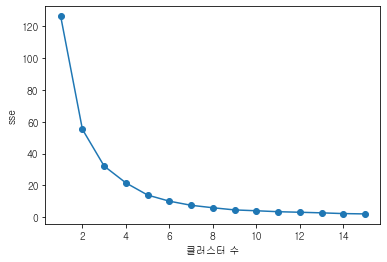

In [13]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

x = df_copy[['청년인구','청년인프라지수']].values

## 방법 elbow기법

from sklearn.cluster import KMeans
init_centroid = "random" # 초기 클러스터 중심을 임의적
#init_centroid = "k-means++" # 기본값

def elbow(x):
    sse = [] #오차제곱합이 최소가 되도록 클러스터의 중심을 결정
    for i in range(1, 16):
        km = KMeans(n_clusters = i, init = "k-means++", random_state = 0)
        km.fit(x)
        sse.append(km.inertia_)
    plt.plot(range(1, 16), sse, marker = "o")
    plt.xlabel("클러스터 수")
    plt.ylabel("sse")
    plt.show()
    
elbow(x)

# k=3,4,5로실시

## k-means

In [15]:
kmodel = KMeans(n_clusters = 3, init = init_centroid, random_state = 0)
print(kmodel)
pred = kmodel.fit_predict(x)
print("pred: ", pred)

center = pd.DataFrame(kmodel.cluster_centers_,
                     index = ['군집1','군집2','군집3'])
center.columns =['청년인구','인프라지수']

center

KMeans(init='random', n_clusters=3, random_state=0)
pred:  [1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 0 1 2 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0
 0 0 0 1 0 0 1 2 0 1 1 0 1 1 1 0 0 0 0 1 1 0 0 0 1 1 1 0 1 2 1 1]


,청년인구,인프라지수
군집1,0.304626,4.167709
군집2,0.414499,5.927771
군집3,0.456396,8.878291


In [16]:
kmodel = KMeans(n_clusters = 4, init = init_centroid, random_state = 0)
print(kmodel)
pred = kmodel.fit_predict(x)
print("pred: ", pred)

center = pd.DataFrame(kmodel.cluster_centers_,
                     index = ['군집1','군집2','군집3','군집4'])
center.columns =['청년인구','청년인프라지수']

center

KMeans(init='random', n_clusters=4, random_state=0)
pred:  [1 1 1 1 1 1 3 1 3 1 1 3 3 1 1 1 3 1 0 3 2 3 3 3 3 3 3 1 3 3 3 0 3 3 1 1 2
 3 3 3 1 3 3 1 0 3 1 0 3 1 1 0 3 3 3 3 1 1 3 3 3 1 1 1 3 1 0 1 1]


,청년인구,청년인프라지수
군집1,0.433811,7.975292
군집2,0.414838,5.809372
군집3,0.031479,1.920906
군집4,0.321698,4.308134


In [17]:
kmodel = KMeans(n_clusters = 5, init = init_centroid, random_state = 0)
print(kmodel)
pred = kmodel.fit_predict(x)
print("pred: ", pred)

center = pd.DataFrame(kmodel.cluster_centers_,
                     index = ['군집1','군집2','군집3','군집4','군집5'])
center.columns =['청년인구','청년인프라지수']

center

KMeans(init='random', n_clusters=5, random_state=0)
pred:  [4 3 4 3 4 4 3 4 3 3 4 3 3 4 3 4 3 4 0 2 1 3 2 2 2 2 3 3 2 3 3 4 2 2 4 3 1
 3 2 2 3 2 3 4 0 2 4 4 3 4 4 4 2 2 2 2 3 4 3 2 2 4 3 4 2 3 0 4 3]


,청년인구,청년인프라지수
군집1,0.456396,8.878291
군집2,0.031479,1.920906
군집3,0.255757,4.004989
군집4,0.400667,5.037529
군집5,0.432520,6.216831


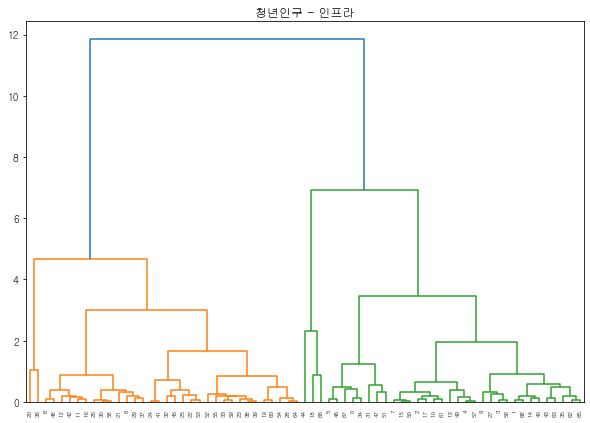

In [23]:
from scipy.cluster.hierarchy import dendrogram, linkage #계층적 군집분석시 필요
from matplotlib import pyplot as plt

df_Den = df_copy.reindex(columns=['청년인구','청년인프라지수'])

linked = linkage(df_Den, 'single')

labelList = df_copy.index


import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("청년인구 - 인프라")
dend = shc.dendrogram(shc.linkage(df_Den, method='ward'))

In [24]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
df_pred = cluster.fit_predict(df_Den)

arr1 = df_Den[df_pred == 0].mean()
arr2 = df_Den[df_pred == 1].mean()
arr3 = df_Den[df_pred == 2].mean()

center = pd.DataFrame([arr1,arr2,arr3],
                     index = ['군집1','군집2','군집3'])

center

,청년인구,청년인프라지수
군집1,0.304626,4.167709
군집2,0.414499,5.927771
군집3,0.456396,8.878291


In [26]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
df_pred = cluster.fit_predict(df_Den)

arr1 = df_Den[df_pred == 0].mean()
arr2 = df_Den[df_pred == 1].mean()
arr3 = df_Den[df_pred == 2].mean()
arr4 = df_Den[df_pred == 3].mean()

center = pd.DataFrame([arr1,arr2,arr3,arr4],
                     index = ['군집1','군집2','군집3','군집4'])

center

,청년인구,청년인프라지수
군집1,0.414499,5.927771
군집2,0.321698,4.308134
군집3,0.456396,8.878291
군집4,0.031479,1.920906


In [27]:
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
df_pred = cluster.fit_predict(df_Den)

arr1 = df_Den[df_pred == 0].mean()
arr2 = df_Den[df_pred == 1].mean()
arr3 = df_Den[df_pred == 2].mean()
arr4 = df_Den[df_pred == 3].mean()
arr5 = df_Den[df_pred == 4].mean()

center = pd.DataFrame([arr1,arr2,arr3,arr4,arr5],
                     index = ['군집1','군집2','군집3','군집4','군집5'])

center

,청년인구,청년인프라지수
군집1,0.321698,4.308134
군집2,0.426284,5.678665
군집3,0.456396,8.878291
군집4,0.031479,1.920906
군집5,0.379145,6.675088
